In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from haversine import haversine, Unit
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from category_encoders.target_encoder import TargetEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [2]:
filled_1850 = pd.read_csv("../data/dwelling_filled_sum_1850_mn.csv")
census_1880 = pd.read_csv("../data/census_1880_mn_v04.csv")
cd_1880 = pd.read_csv("../data/cd_1880.csv")
disamb_1880 = pd.read_csv("../data/disambiguated-21-5-2020.csv")

/Users/tabithasugumar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
dwellings_1850 = filled_1850.groupby(["CENSUS_WARD_NUM", "CENSUS_DWELLING_NUM"], as_index = False).first()
dwellings_1850.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19825 entries, 0 to 19824
Data columns (total 32 columns):
CENSUS_WARD_NUM            19825 non-null int64
CENSUS_DWELLING_NUM        19825 non-null float64
BLOCK_NUM                  7524 non-null float64
CD_ADDRESS                 7524 non-null object
CD_X                       7524 non-null float64
CD_Y                       7524 non-null float64
CENSUS_AGE                 19825 non-null int64
CENSUS_CITY                19825 non-null int64
CENSUS_DWELLING_SEQ        19812 non-null float64
CENSUS_DWELLING_SIZE       19825 non-null int64
CENSUS_GEOG                19817 non-null object
CENSUS_HH_NUM              19825 non-null int64
CENSUS_ID                  7524 non-null object
CENSUS_IMPREL              19825 non-null int64
CENSUS_INDEX               19825 non-null int64
CENSUS_IPUMS_UID           19825 non-null object
CENSUS_LABFORCE            19825 non-null int64
CENSUS_LINE                19825 non-null int64
CENSUS_MARST      

In [4]:
dwellings_1850.head(30)

,CENSUS_WARD_NUM,CENSUS_DWELLING_NUM,BLOCK_NUM,CD_ADDRESS,CD_X,CD_Y,CENSUS_AGE,CENSUS_CITY,CENSUS_DWELLING_SEQ,CENSUS_DWELLING_SIZE,...,CENSUS_PAGENO_HOUSEHOLD,CENSUS_PLACE,CENSUS_RACE,CENSUS_REEL_HOUSEHOLD,CENSUS_SEQ_NUM,CENSUS_SERIALP,CENSUS_SEX,selected,spatial_weight,spatial_weight_sum
0,1,1.0,3794.0,37 South,-74.008250,40.703128,49,4610,1.0,84,...,70,MANHATTAN,120,534,1,2044262,1,1.0,2.00,2.00
1,1,2.0,NaN,NaN,NaN,NaN,24,4610,2.0,3,...,100,MANHATTAN,120,534,1,2044348,1,NaN,NaN,NaN
2,1,3.0,NaN,NaN,NaN,NaN,26,4610,3.0,1,...,100,MANHATTAN,120,534,1,2044349,1,NaN,NaN,NaN
3,1,4.0,713.0,76 Liberty,-74.007679,40.707284,23,4610,4.0,1,...,100,MANHATTAN,120,534,1,2044350,1,1.0,1.74,1.74
4,1,5.0,NaN,NaN,NaN,NaN,30,4610,5.0,3,...,100,MANHATTAN,120,534,1,2044351,1,NaN,NaN,NaN
5,1,6.0,709.0,46 Cedar,-74.009067,40.707572,25,4610,6.0,3,...,110,MANHATTAN,120,534,1,2044352,1,1.0,2.00,2.00
6,1,7.0,682.0,102 Liberty |,-74.011747,40.709673,22,4610,7.0,1,...,110,MANHATTAN,120,534,1,2044353,1,1.0,1.95,1.95
7,1,8.0,NaN,NaN,NaN,NaN,35,4610,8.0,8,...,110,MANHATTAN,120,534,1,2044354,1,NaN,NaN,NaN
8,1,9.0,718.0,163 Pearl,-74.007680,40.705869,22,4610,9.0,1,...,110,MANHATTAN,120,534,1,2044355,1,1.0,1.96,1.96
9,1,10.0,NaN,NaN,NaN,NaN,40,4610,10.0,2,...,110,MANHATTAN,120,534,1,2044356,1,NaN,NaN,NaN


In [5]:
dwellings_1850_ward_1 = dwellings_1850[dwellings_1850["CENSUS_WARD_NUM"] == 1]
print(min(dwellings_1850_ward_1["BLOCK_NUM"]), max(dwellings_1850_ward_1["BLOCK_NUM"]))

1.0 3802.0


In [6]:
print(dwellings_1850_ward_1["BLOCK_NUM"].nunique())

68


In [7]:
dwellings_1850_ward_1 = dwellings_1850_ward_1[0:30]

This indicates that very large differences in block numbers don't necessarily correspond to correspond to huge geographic breaks in the enumeration pattern. Let's try graphing one ward and trying to get a sense of where things are.

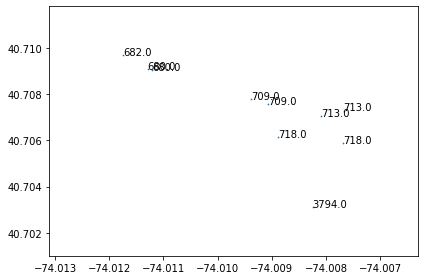

In [8]:
plt.scatter(dwellings_1850_ward_1["CD_X"], dwellings_1850_ward_1["CD_Y"], s = 0.5)
for x, y, block in zip(dwellings_1850_ward_1["CD_X"], dwellings_1850_ward_1["CD_Y"], dwellings_1850_ward_1["BLOCK_NUM"]):
    plt.annotate(block, (x,y))
plt.tight_layout()
plt.show()

So an overlay here would probably be more useful, but this works to get a sense of what's happening. Since the geography is signficant intuitively, could we create sequences by using a distance as a measurement? The problem here is that we couldn't really assume a street but doing that on a grand scale is somewhat problematic regardless. Having sequences that actually make sense would be really helpful

In [9]:
#This preserves the original index, we can get the number of dwellings in between by 
dwellings_1850_add = dwellings_1850.dropna(subset = ["CD_ADDRESS"]).copy() 
dwellings_1850_add.head()

,CENSUS_WARD_NUM,CENSUS_DWELLING_NUM,BLOCK_NUM,CD_ADDRESS,CD_X,CD_Y,CENSUS_AGE,CENSUS_CITY,CENSUS_DWELLING_SEQ,CENSUS_DWELLING_SIZE,...,CENSUS_PAGENO_HOUSEHOLD,CENSUS_PLACE,CENSUS_RACE,CENSUS_REEL_HOUSEHOLD,CENSUS_SEQ_NUM,CENSUS_SERIALP,CENSUS_SEX,selected,spatial_weight,spatial_weight_sum
0,1,1.0,3794.0,37 South,-74.008250,40.703128,49,4610,1.0,84,...,70,MANHATTAN,120,534,1,2044262,1,1.0,2.00,2.00
3,1,4.0,713.0,76 Liberty,-74.007679,40.707284,23,4610,4.0,1,...,100,MANHATTAN,120,534,1,2044350,1,1.0,1.74,1.74
5,1,6.0,709.0,46 Cedar,-74.009067,40.707572,25,4610,6.0,3,...,110,MANHATTAN,120,534,1,2044352,1,1.0,2.00,2.00
6,1,7.0,682.0,102 Liberty |,-74.011747,40.709673,22,4610,7.0,1,...,110,MANHATTAN,120,534,1,2044353,1,1.0,1.95,1.95
8,1,9.0,718.0,163 Pearl,-74.007680,40.705869,22,4610,9.0,1,...,110,MANHATTAN,120,534,1,2044355,1,1.0,1.96,1.96


In [10]:
dwellings_1850_add["dwelling_num_listed"] = dwellings_1850_add.index
dwellings_1850_add["next_dnl"] = dwellings_1850_add["dwelling_num_listed"].shift(-1)
dwellings_1850_add["next_x"] = dwellings_1850_add["CD_X"].shift(-1)
dwellings_1850_add["next_y"] = dwellings_1850_add["CD_Y"].shift(-1)
dwellings_1850_add["next_ward"] = dwellings_1850_add["CENSUS_WARD_NUM"].shift(-1)
dwellings_1850_add["next_dwelling_num"] = dwellings_1850_add["CENSUS_DWELLING_NUM"].shift(-1)
dwellings_1850_add["next_address"] = dwellings_1850_add["CD_ADDRESS"].shift(-1)
dwellings_1850_add["next_block_num"] = dwellings_1850_add["BLOCK_NUM"].shift(-1)
dwellings_1850_add['dist'] = dwellings_1850_add.apply(lambda row: haversine((row["CD_X"], row["CD_Y"]), (row["next_x"], row["next_y"]), unit=Unit.MILES), axis=1)
dwellings_1850_add["num_between"] = dwellings_1850_add["next_dnl"] - dwellings_1850_add["dwelling_num_listed"] #really number between plus one
dwellings_1850_add.head()

,CENSUS_WARD_NUM,CENSUS_DWELLING_NUM,BLOCK_NUM,CD_ADDRESS,CD_X,CD_Y,CENSUS_AGE,CENSUS_CITY,CENSUS_DWELLING_SEQ,CENSUS_DWELLING_SIZE,...,dwelling_num_listed,next_dnl,next_x,next_y,next_ward,next_dwelling_num,next_address,next_block_num,dist,num_between
0,1,1.0,3794.0,37 South,-74.008250,40.703128,49,4610,1.0,84,...,0,3.0,-74.007679,40.707284,1.0,4.0,76 Liberty,713.0,0.088400,3.0
3,1,4.0,713.0,76 Liberty,-74.007679,40.707284,23,4610,4.0,1,...,3,5.0,-74.009067,40.707572,1.0,6.0,46 Cedar,709.0,0.096077,2.0
5,1,6.0,709.0,46 Cedar,-74.009067,40.707572,25,4610,6.0,3,...,5,6.0,-74.011747,40.709673,1.0,7.0,102 Liberty |,682.0,0.189482,1.0
6,1,7.0,682.0,102 Liberty |,-74.011747,40.709673,22,4610,7.0,1,...,6,8.0,-74.007680,40.705869,1.0,9.0,163 Pearl,718.0,0.290189,2.0
8,1,9.0,718.0,163 Pearl,-74.007680,40.705869,22,4610,9.0,1,...,8,20.0,-74.009386,40.707772,1.0,21.0,58 Cedar,709.0,0.123281,12.0


In [11]:
print("Distance Range:", min(dwellings_1850_add["dist"]), "-", max(dwellings_1850_add["dist"]))

Distance Range: 0.0 - 1.30390875173007


In [12]:
dwellings_1850_add[dwellings_1850_add["dist"] == 0]

,CENSUS_WARD_NUM,CENSUS_DWELLING_NUM,BLOCK_NUM,CD_ADDRESS,CD_X,CD_Y,CENSUS_AGE,CENSUS_CITY,CENSUS_DWELLING_SEQ,CENSUS_DWELLING_SIZE,...,dwelling_num_listed,next_dnl,next_x,next_y,next_ward,next_dwelling_num,next_address,next_block_num,dist,num_between
78,1,79.0,3797.0,6 Stone,-74.012503,40.704005,35,4610,186.0,6,...,78,79.0,-74.012503,40.704005,1.0,80.0,6 Stone,3797.0,0.0,1.0
393,1,394.0,7.0,32 Trinity place,-74.012491,40.708354,38,4610,917.0,10,...,393,394.0,-74.012491,40.708354,1.0,395.0,32 Trinity pl,7.0,0.0,1.0
401,1,402.0,7.0,40 Trinity pl,-74.012659,40.708114,26,4610,926.0,6,...,401,402.0,-74.012659,40.708114,1.0,403.0,40 Trinity pl,7.0,0.0,1.0
723,2,147.0,854.0,60 Fulton,-74.005101,40.708625,47,4610,467.0,3,...,723,724.0,-74.005101,40.708625,2.0,148.0,60 Falton,854.0,0.0,1.0
785,2,209.0,852.0,5 Lower Fulton market,-74.002791,40.707891,34,4610,579.0,6,...,785,786.0,-74.002791,40.707891,2.0,210.0,5 Fulton,852.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16497,17,655.0,245.0,270 Houston ;,-73.984961,40.721642,51,4610,1864.0,4,...,16497,16498.0,-73.984961,40.721642,17.0,656.0,270 Houston,245.0,0.0,1.0
16521,17,679.0,204.0,142 Suffolk,-73.985503,40.719963,60,4610,1915.0,5,...,16521,16524.0,-73.985503,40.719963,17.0,682.0,142 Suffolk,204.0,0.0,3.0
16696,17,854.0,246.0,16 Av . A,-73.985814,40.722717,17,4610,2779.0,4,...,16696,16697.0,-73.985814,40.722717,17.0,855.0,16 Av . A,246.0,0.0,1.0
17015,18,111.0,1033.0,29 Coenties sl,-73.986101,40.739141,43,4610,240.0,7,...,17015,17016.0,-73.986101,40.739141,18.0,112.0,62 E . 22d,1033.0,0.0,1.0


/Users/tabithasugumar/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:403: RuntimeWarning: invalid value encountered in greater_equal
  keep = (a >= first_edge)
/Users/tabithasugumar/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:404: RuntimeWarning: invalid value encountered in less_equal
  keep &= (a <= last_edge)
/Users/tabithasugumar/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/tabithasugumar/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


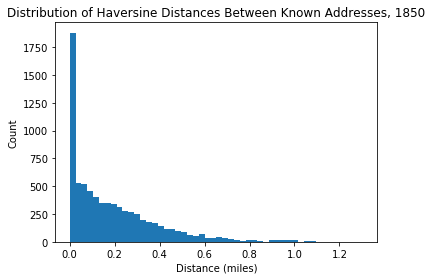

In [13]:
### Let's look at the distribution of distances
plt.hist(dwellings_1850_add["dist"], bins = "auto")
plt.title("Distribution of Haversine Distances Between Known Addresses, 1850")
plt.xlabel("Distance (miles)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Looking at this graph, and considering that these are the distances between consecutive dwellings, let's try sequences split on when it's farther than 0.1 to the next dwelling

In [14]:
dwellings_1850_add["sequence_id"] = np.where(dwellings_1850_add["dist"] > 0.1, dwellings_1850_add["dist"].index, np.nan)

In [15]:
dwellings_1850_add.head()

,CENSUS_WARD_NUM,CENSUS_DWELLING_NUM,BLOCK_NUM,CD_ADDRESS,CD_X,CD_Y,CENSUS_AGE,CENSUS_CITY,CENSUS_DWELLING_SEQ,CENSUS_DWELLING_SIZE,...,next_dnl,next_x,next_y,next_ward,next_dwelling_num,next_address,next_block_num,dist,num_between,sequence_id
0,1,1.0,3794.0,37 South,-74.008250,40.703128,49,4610,1.0,84,...,3.0,-74.007679,40.707284,1.0,4.0,76 Liberty,713.0,0.088400,3.0,NaN
3,1,4.0,713.0,76 Liberty,-74.007679,40.707284,23,4610,4.0,1,...,5.0,-74.009067,40.707572,1.0,6.0,46 Cedar,709.0,0.096077,2.0,NaN
5,1,6.0,709.0,46 Cedar,-74.009067,40.707572,25,4610,6.0,3,...,6.0,-74.011747,40.709673,1.0,7.0,102 Liberty |,682.0,0.189482,1.0,5.0
6,1,7.0,682.0,102 Liberty |,-74.011747,40.709673,22,4610,7.0,1,...,8.0,-74.007680,40.705869,1.0,9.0,163 Pearl,718.0,0.290189,2.0,6.0
8,1,9.0,718.0,163 Pearl,-74.007680,40.705869,22,4610,9.0,1,...,20.0,-74.009386,40.707772,1.0,21.0,58 Cedar,709.0,0.123281,12.0,8.0


In [16]:
dwellings_1850_add["sequence_id"].bfill(inplace = True)
dwellings_1850_add.head()

,CENSUS_WARD_NUM,CENSUS_DWELLING_NUM,BLOCK_NUM,CD_ADDRESS,CD_X,CD_Y,CENSUS_AGE,CENSUS_CITY,CENSUS_DWELLING_SEQ,CENSUS_DWELLING_SIZE,...,next_dnl,next_x,next_y,next_ward,next_dwelling_num,next_address,next_block_num,dist,num_between,sequence_id
0,1,1.0,3794.0,37 South,-74.008250,40.703128,49,4610,1.0,84,...,3.0,-74.007679,40.707284,1.0,4.0,76 Liberty,713.0,0.088400,3.0,5.0
3,1,4.0,713.0,76 Liberty,-74.007679,40.707284,23,4610,4.0,1,...,5.0,-74.009067,40.707572,1.0,6.0,46 Cedar,709.0,0.096077,2.0,5.0
5,1,6.0,709.0,46 Cedar,-74.009067,40.707572,25,4610,6.0,3,...,6.0,-74.011747,40.709673,1.0,7.0,102 Liberty |,682.0,0.189482,1.0,5.0
6,1,7.0,682.0,102 Liberty |,-74.011747,40.709673,22,4610,7.0,1,...,8.0,-74.007680,40.705869,1.0,9.0,163 Pearl,718.0,0.290189,2.0,6.0
8,1,9.0,718.0,163 Pearl,-74.007680,40.705869,22,4610,9.0,1,...,20.0,-74.009386,40.707772,1.0,21.0,58 Cedar,709.0,0.123281,12.0,8.0


In [17]:
dwellings_1850_add.groupby("sequence_id").ngroups

4211

In [18]:
dwellings_1850_add["sequence_len"] = dwellings_1850_add.groupby("sequence_id")["num_between"].transform('sum')
dwellings_1850_add.head()

,CENSUS_WARD_NUM,CENSUS_DWELLING_NUM,BLOCK_NUM,CD_ADDRESS,CD_X,CD_Y,CENSUS_AGE,CENSUS_CITY,CENSUS_DWELLING_SEQ,CENSUS_DWELLING_SIZE,...,next_x,next_y,next_ward,next_dwelling_num,next_address,next_block_num,dist,num_between,sequence_id,sequence_len
0,1,1.0,3794.0,37 South,-74.008250,40.703128,49,4610,1.0,84,...,-74.007679,40.707284,1.0,4.0,76 Liberty,713.0,0.088400,3.0,5.0,6.0
3,1,4.0,713.0,76 Liberty,-74.007679,40.707284,23,4610,4.0,1,...,-74.009067,40.707572,1.0,6.0,46 Cedar,709.0,0.096077,2.0,5.0,6.0
5,1,6.0,709.0,46 Cedar,-74.009067,40.707572,25,4610,6.0,3,...,-74.011747,40.709673,1.0,7.0,102 Liberty |,682.0,0.189482,1.0,5.0,6.0
6,1,7.0,682.0,102 Liberty |,-74.011747,40.709673,22,4610,7.0,1,...,-74.007680,40.705869,1.0,9.0,163 Pearl,718.0,0.290189,2.0,6.0,2.0
8,1,9.0,718.0,163 Pearl,-74.007680,40.705869,22,4610,9.0,1,...,-74.009386,40.707772,1.0,21.0,58 Cedar,709.0,0.123281,12.0,8.0,12.0


In [19]:
print("Range of sequence lengths:", min(dwellings_1850_add["sequence_len"]), "-", max(dwellings_1850_add["sequence_len"]))

Range of sequence lengths: 1.0 - 1084.0


In [20]:
def get_dist_seq(dataframe, d):
    df = dataframe.copy()
    df["sequence_id"] = np.where(df["dist"] > d, df["dist"].index, np.nan)
    df["sequence_id"].bfill(inplace = True)
    df["sequence_len"] = df.groupby("sequence_id")["num_between"].transform('sum')
    return [min(df["sequence_len"]), max(df["sequence_len"]), df]

In [21]:
# Let's test a few sequence division options
options = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]

for op in options:
    obj = get_dist_seq(dwellings_1850_add, op)
    print("Minimum Length with division dist", op, ":", obj[0])
    print("Maximum Length with division dist", op, ":", obj[1])

Minimum Length with division dist 0.1 : 1.0
Maximum Length with division dist 0.1 : 1084.0
Minimum Length with division dist 0.15 : 1.0
Maximum Length with division dist 0.15 : 1054.0
Minimum Length with division dist 0.2 : 1.0
Maximum Length with division dist 0.2 : 1054.0
Minimum Length with division dist 0.25 : 1.0
Maximum Length with division dist 0.25 : 1054.0
Minimum Length with division dist 0.3 : 1.0
Maximum Length with division dist 0.3 : 1148.0
Minimum Length with division dist 0.35 : 1.0
Maximum Length with division dist 0.35 : 1234.0
Minimum Length with division dist 0.4 : 1.0
Maximum Length with division dist 0.4 : 1234.0


This indicates that 0.15 may make the most sense as far as a division goes, there's still a huge amount of variablity in the sequence lengths though. Let's look at the really short sequences.

In [22]:
dwellings_1850_seq  = get_dist_seq(dwellings_1850_add, .15)[2]
dwellings_1850_seq[dwellings_1850_seq["sequence_len"] == 1]

,CENSUS_WARD_NUM,CENSUS_DWELLING_NUM,BLOCK_NUM,CD_ADDRESS,CD_X,CD_Y,CENSUS_AGE,CENSUS_CITY,CENSUS_DWELLING_SEQ,CENSUS_DWELLING_SIZE,...,next_x,next_y,next_ward,next_dwelling_num,next_address,next_block_num,dist,num_between,sequence_id,sequence_len
58,1,59.0,3781.0,47 Front,-74.009378,40.703039,46,4610,95.0,32,...,-74.014034,40.706597,1.0,60.0,51 Greenwich R,663.0,0.328745,1.0,58.0,1.0
66,1,67.0,682.0,123 Cedar,-74.012489,40.709591,40,4610,135.0,6,...,-74.008438,40.704024,1.0,68.0,24 Old slip,700.0,0.299281,1.0,66.0,1.0
71,1,72.0,3797.0,12 Stone:,-74.012247,40.703998,30,4610,151.0,6,...,-74.005920,40.705107,1.0,73.0,93 Pine,707.0,0.437609,1.0,71.0,1.0
72,1,73.0,707.0,93 Pine,-74.005920,40.705107,25,4610,157.0,2,...,-74.013065,40.702812,1.0,74.0,40 Whitehall,649.0,0.495584,1.0,72.0,1.0
73,1,74.0,649.0,40 Whitehall,-74.013065,40.702812,60,4610,160.0,14,...,-74.009819,40.708802,1.0,75.0,60 Liberty,704.0,0.251584,1.0,73.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17689,18,785.0,1627.0,109 Elizabeth,-73.983044,40.741673,40,4610,1829.0,13,...,-73.987308,40.739808,18.0,786.0,45 E . 22d,634.0,0.296763,1.0,17689.0,1.0
17773,18,869.0,634.0,296 Fourth _,-73.986612,40.740092,45,4610,1957.0,5,...,-73.978227,40.740130,18.0,870.0,45 Rose,1641.0,0.579305,1.0,17773.0,1.0
17810,18,906.0,453.0,88 Broadway,-73.982553,40.742304,60,4610,1994.0,10,...,-73.986868,40.744981,18.0,907.0,243 Fifth ||,1415.0,0.302443,1.0,17810.0,1.0
17825,18,921.0,452.0,E . 32d c . Lexington Av,-73.982931,40.742213,52,4610,2009.0,20,...,-73.988330,40.734795,18.0,922.0,6 Wall,1022.0,0.398963,1.0,17825.0,1.0


In [23]:
dwellings_1850_seq.groupby("sequence_id").ngroups

3469

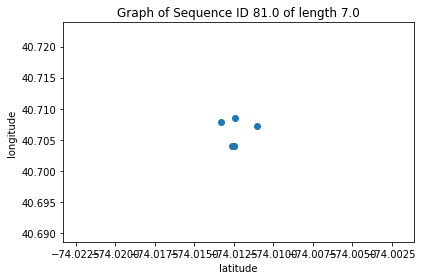

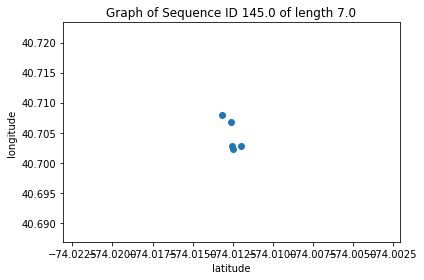

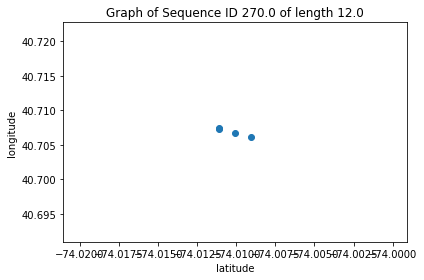

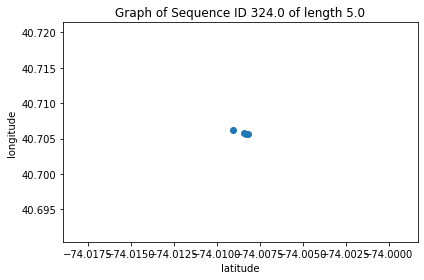

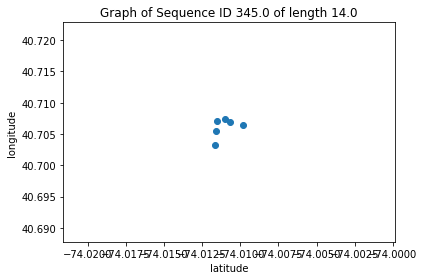

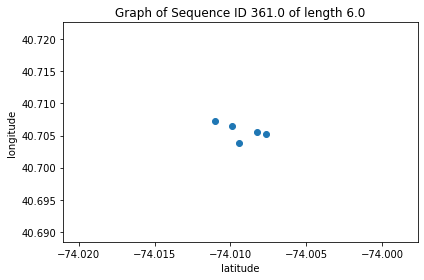

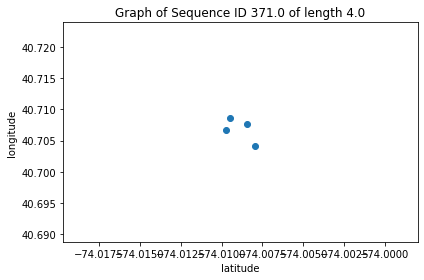

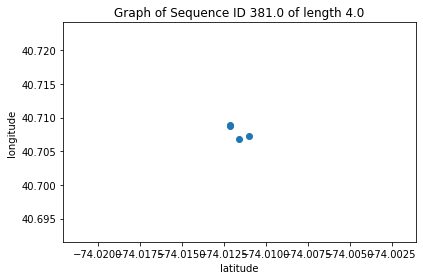

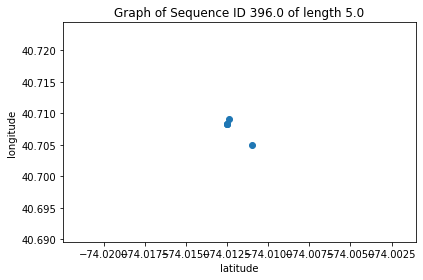

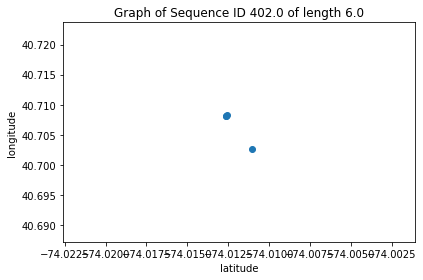

In [24]:
# Let's try plotting some sequences so that we can see whether they look sort of like sequences
i = 0
for id, group in dwellings_1850_seq.groupby("sequence_id"):
    if len(group) > 3:
        plt.scatter(group["CD_X"], group["CD_Y"])
        plt.title("Graph of Sequence ID "+str(id)+ " of length " + str(group["sequence_len"].iloc[0]))
        plt.xlabel("latitude")
        plt.ylabel("longitude")
        plt.tight_layout()
        plt.show()
        i += 1
    if i == 10:
        break

Again, it would be great to get an overlay here, but from a visual inspection these sequences look like they make some level of sense. I think it makes sense to try them in the linear model for now, as a category and see if they help. It may also be worth experimenting with the options for including the sequence order

What I need to do is join this so that every entry that fits has the appropriate sequence id

In [25]:
#Add sequences into the orginal data
all_seq = filled_1850.dropna(subset = ["CD_ADDRESS"]).merge(dwellings_1850_seq.loc[:,["CENSUS_WARD_NUM", "CENSUS_DWELLING_NUM", "sequence_id"]], how = 'left', on = ["CENSUS_WARD_NUM", "CENSUS_DWELLING_NUM"], validate = 'many_to_one')
all_seq.head()

,BLOCK_NUM,CD_ADDRESS,CD_X,CD_Y,CENSUS_AGE,CENSUS_CITY,CENSUS_DWELLING_NUM,CENSUS_DWELLING_SEQ,CENSUS_DWELLING_SIZE,CENSUS_GEOG,...,CENSUS_RACE,CENSUS_REEL_HOUSEHOLD,CENSUS_SEQ_NUM,CENSUS_SERIALP,CENSUS_SEX,CENSUS_WARD_NUM,selected,spatial_weight,spatial_weight_sum,sequence_id
0,3794.0,37 South,-74.00825,40.703128,49,4610,1.0,1.0,84,NEW YORK WARD 1 EASTERN DIVISION,...,120,534,1,2044262,1,1,NaN,NaN,NaN,5.0
1,3794.0,37 South,-74.00825,40.703128,36,4610,1.0,1.0,84,NEW YORK WARD 1 EASTERN DIVISION,...,120,534,2,2044263,2,1,NaN,NaN,NaN,5.0
2,3794.0,37 South,-74.00825,40.703128,12,4610,1.0,1.0,84,NEW YORK WARD 1 EASTERN DIVISION,...,120,534,3,2044264,2,1,NaN,NaN,NaN,5.0
3,3794.0,37 South,-74.00825,40.703128,40,4610,1.0,1.0,84,NEW YORK WARD 1 EASTERN DIVISION,...,120,534,4,2044265,1,1,NaN,NaN,NaN,5.0
4,3794.0,37 South,-74.00825,40.703128,28,4610,1.0,1.0,84,NEW YORK WARD 1 EASTERN DIVISION,...,120,534,5,2044266,2,1,NaN,NaN,NaN,5.0


In [26]:
all_seq.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261460 entries, 0 to 261459
Data columns (total 33 columns):
BLOCK_NUM                  261460 non-null float64
CD_ADDRESS                 261460 non-null object
CD_X                       261460 non-null float64
CD_Y                       261460 non-null float64
CENSUS_AGE                 261460 non-null int64
CENSUS_CITY                261460 non-null int64
CENSUS_DWELLING_NUM        261427 non-null float64
CENSUS_DWELLING_SEQ        260535 non-null float64
CENSUS_DWELLING_SIZE       261460 non-null int64
CENSUS_GEOG                261030 non-null object
CENSUS_HH_NUM              261460 non-null int64
CENSUS_ID                  12348 non-null object
CENSUS_IMPREL              261460 non-null int64
CENSUS_INDEX               261460 non-null int64
CENSUS_IPUMS_UID           261460 non-null object
CENSUS_LABFORCE            261460 non-null int64
CENSUS_LINE                261460 non-null int64
CENSUS_MARST               261460 non-null 

In [27]:
dwellings_1880 = census_1880.drop_duplicates(subset = ["CENSUS_ADDRESS"]).reset_index(drop = True).copy()

In [28]:
dwellings_1880.loc[dwellings_1880.CENSUS_Y > 1000, 'CENSUS_Y'] = 40.799935

In [29]:
dwellings_1880["dwelling_num_listed"] = dwellings_1880.index
dwellings_1880["next_dnl"] = dwellings_1880["dwelling_num_listed"].shift(-1)
dwellings_1880["next_x"] = dwellings_1880["CENSUS_X"].shift(-1)
dwellings_1880["next_y"] = dwellings_1880["CENSUS_Y"].shift(-1)
dwellings_1880["next_ward"] = dwellings_1880["WARD_NUM"].shift(-1)
dwellings_1880["next_address"] = dwellings_1880["CENSUS_ADDRESS"].shift(-1)
dwellings_1880['dist'] = dwellings_1880.apply(lambda row: haversine((row["CENSUS_X"], row["CENSUS_Y"]), (row["next_x"], row["next_y"]), unit=Unit.MILES), axis=1)
dwellings_1880["num_between"] = dwellings_1880["next_dnl"] - dwellings_1880["dwelling_num_listed"] #really number between plus one
dwellings_1880.head()

,OBJECTID.x,CENSUS_MERGEID,CENSUS_SERIALB,CENSUS_SERIAL,CENSUS_PERNUM,CENSUS_RECIDUS,CENSUS_REEL,CENSUS_VOLUME,CENSUS_PAGENUM,CENSUS_NAMEFRSTB,...,WARD_NUM,CENSUS_AD,dwelling_num_listed,next_dnl,next_x,next_y,next_ward,next_address,dist,num_between
0,1,46101106EDITH K.SANGER,6347938,6198399,3,01254866-1-0001-0003-$,866,1,1,EDITH K.,...,1.0,1.0,0,1.0,-74.016451,40.690645,1.0,43 GOVERNORS ISLAND,0.020766,1.0
1,7,4610121181JAMES E.---,6347939,0,1,01254866-1-0001-0007-$,866,1,1,JAMES E.,...,1.0,1.0,1,2.0,-74.017310,40.691119,1.0,16 GOVERNORS ISLAND,0.060032,1.0
2,9,461010HENRY W.---,6347940,0,0,NaN,0,0,0,HENRY W.,...,1.0,1.0,2,3.0,-74.016725,40.690844,1.0,33 GOVERNORS ISLAND,0.040757,1.0
3,16,461011007MAY---,6347941,0,3,01254866-1-0001-0017-$,866,1,1,MAY,...,1.0,1.0,3,4.0,-74.017031,40.690915,1.0,26 GOVERNORS ISLAND,0.021186,1.0
4,23,461011503AGNESCREIGHTEN,6347942,6198403,3,01254866-1-0001-0024-$,866,1,1,AGNES,...,1.0,1.0,4,5.0,-74.015465,40.689925,1.0,79 GOVERNORS ISLAND,0.109828,1.0


In [30]:
print("Maximum distance:", max(dwellings_1880["dist"]))
print("Minimum distance:", min(dwellings_1880["dist"]))

Maximum distance: 4.406896866285562
Minimum distance: 0.00029922284205678864


In [31]:
print(len(dwellings_1880))

57961


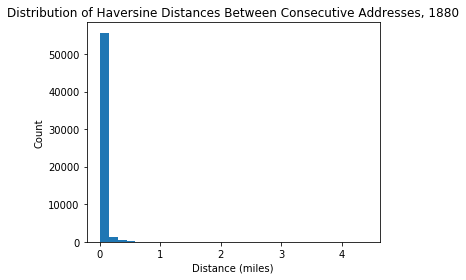

In [32]:
plt.hist(dwellings_1880["dist"], bins =  30)
plt.title("Distribution of Haversine Distances Between Consecutive Addresses, 1880")
plt.xlabel("Distance (miles)")
plt.ylabel("Count")
#plt.ylim([0,10000])
plt.tight_layout()
plt.show()

In [33]:
seq_1880 = get_dist_seq(dwellings_1880, .15)[2]

In [34]:
all_seq_1880 = census_1880.merge(seq_1880.loc[:,["CENSUS_MATCH_ADDR", "sequence_id"]], how = "left", on = "CENSUS_MATCH_ADDR",validate = "many_to_one")
all_seq_1880.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1117479 entries, 0 to 1117478
Data columns (total 43 columns):
OBJECTID.x           1117479 non-null int64
CENSUS_MERGEID       1117479 non-null object
CENSUS_SERIALB       1117479 non-null int64
CENSUS_SERIAL        1117479 non-null int64
CENSUS_PERNUM        1117479 non-null int64
CENSUS_RECIDUS       1117158 non-null object
CENSUS_REEL          1117479 non-null int64
CENSUS_VOLUME        1117479 non-null int64
CENSUS_PAGENUM       1117479 non-null int64
CENSUS_NAMEFRSTB     1117479 non-null object
CENSUS_NAMELASTB     1117479 non-null object
CENSUS_RELATE        1117479 non-null int64
CENSUS_RELATE_STR    1117479 non-null object
CENSUS_AGE           1117479 non-null int64
CENSUS_SEXB          1117479 non-null int64
CENSUS_RACENAMEB     1117479 non-null object
CENSUS_RACEB         1117479 non-null int64
CENSUS_NPERHHB       1117479 non-null int64
CENSUS_OCCLABELB     1117322 non-null object
CENSUS_SEIUSBN       1117479 non-null int64


In [35]:
def create_street_house(df, address):
    df[["house_number", "street_name"]] = df[address].str.split(" ", 1, expand = True)
    df["house_number"] = df["house_number"].str.extract(r'(\d+)')#.astype('int64', errors = 'ignore') #deal with numbers when they are listed as 124-125 (choose the first one) there's also one that's 2A which becomes 2 
    df["house_number"] = df["house_number"].apply(pd.to_numeric, errors='coerce').dropna()

In [36]:
create_street_house(all_seq_1880, "CENSUS_ADDRESS")
create_street_house(all_seq, "CD_ADDRESS")

### Linear Model with these sequences

In [37]:
all_seq_1880_dropped = all_seq_1880.dropna(subset = ["house_number"])
all_seq_1850_dropped = all_seq.dropna(subset = ["house_number"])

In [38]:
census_1880_model_X = all_seq_1880_dropped.fillna("None").loc[:,["CENSUS_SERIALB","WARD_NUM","street_name", "sequence_id"]]
census_1880_model_y = all_seq_1880_dropped.loc[:,["house_number"]]
census_1850_model_X = all_seq_1850_dropped.fillna("None").loc[:,["CENSUS_SERIALP", "CENSUS_WARD_NUM", "street_name", "sequence_id"]]
census_1850_model_y = all_seq_1850_dropped.loc[:,["house_number"]]
census_1850_model_X.rename(columns = {"CENSUS_WARD_NUM":"WARD_NUM", "CENSUS_SERIALP":"CENSUS_SERIALB"}, inplace = True)

In [39]:
train_1880_X, test_1880_X, train_1880_y, test_1880_y = train_test_split(census_1880_model_X, census_1880_model_y)
train_1850_X, test_1850_X, train_1850_y, test_1850_y = train_test_split(census_1850_model_X, census_1850_model_y)
train_X = pd.concat([train_1880_X, train_1850_X])
train_y = pd.concat([train_1880_y, train_1850_y])

In [40]:
model_lin_order = Pipeline([('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB","WARD_NUM","street_name", "sequence_id"])),
                            ('regressor', LinearRegression())])
model_lin_order.fit(train_X, train_y)
print("Training score:", model_lin_order.score(train_X, train_y))
print("Test 1850 score:", model_lin_order.score(test_1850_X, test_1850_y))
print("Test 1880 score:", model_lin_order.score(test_1880_X, test_1880_y))

Training score: 0.9686692555647074
Test 1850 score: 0.8282138048078804
Test 1880 score: 0.8882760837487694


In [41]:
print(model_lin_order.named_steps['preprocess'].get_feature_names())
print(model_lin_order.named_steps["regressor"].coef_)

['CENSUS_SERIALB', 'WARD_NUM', 'street_name', 'sequence_id']
[[0.9265719  0.00557533 0.07692663 0.10694277]]


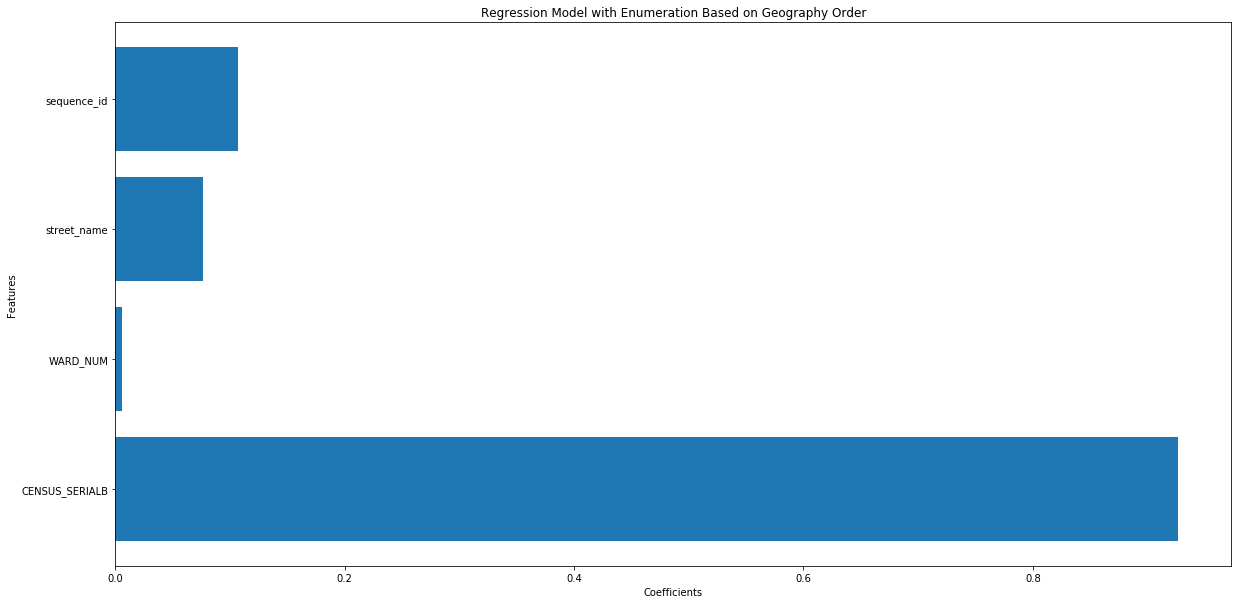

In [42]:
fig, ax = plt.subplots(1, figsize=(20,10))
ax.barh(model_lin_order.named_steps['preprocess'].get_feature_names(), model_lin_order.named_steps["regressor"].coef_[0])
ax.set_title("Regression Model with Enumeration Based on Geography Order")
ax.set_xlabel("Coefficients")
ax.set_ylabel("Features")
plt.show()

So this clearly creating sequences this way works pretty well. Let's try incorporating order of the sequence beyond the sequence id.

In [43]:
#This will be a little different for 1850 and 1880, but if we design for 1850 it should work for 1880
def sequence_order(df):
    df["sequence_order"] = df["num_between"].cumsum()
    return df

In [44]:
dwelling_seq_1850_order = dwellings_1850_seq.groupby("sequence_id").apply(sequence_order)

In [45]:
dwelling_seq_1850_order_dropped = dwelling_seq_1850_order.groupby(["CENSUS_WARD_NUM", "CENSUS_DWELLING_NUM"], as_index = False).first()
dwelling_seq_1850_order_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7522 entries, 0 to 7521
Data columns (total 45 columns):
CENSUS_WARD_NUM            7522 non-null float64
CENSUS_DWELLING_NUM        7522 non-null float64
BLOCK_NUM                  7522 non-null float64
CD_ADDRESS                 7522 non-null object
CD_X                       7522 non-null float64
CD_Y                       7522 non-null float64
CENSUS_AGE                 7522 non-null float64
CENSUS_CITY                7522 non-null float64
CENSUS_DWELLING_SEQ        7519 non-null float64
CENSUS_DWELLING_SIZE       7522 non-null float64
CENSUS_GEOG                7522 non-null object
CENSUS_HH_NUM              7522 non-null float64
CENSUS_ID                  7522 non-null object
CENSUS_IMPREL              7522 non-null float64
CENSUS_INDEX               7522 non-null float64
CENSUS_IPUMS_UID           7522 non-null object
CENSUS_LABFORCE            7522 non-null float64
CENSUS_LINE                7522 non-null float64
CENSUS_MARST   

In [46]:
dwelling_seq_1850_order.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7524 entries, 0 to 19730
Data columns (total 45 columns):
CENSUS_WARD_NUM            7522 non-null float64
CENSUS_DWELLING_NUM        7522 non-null float64
BLOCK_NUM                  7522 non-null float64
CD_ADDRESS                 7522 non-null object
CD_X                       7522 non-null float64
CD_Y                       7522 non-null float64
CENSUS_AGE                 7522 non-null float64
CENSUS_CITY                7522 non-null float64
CENSUS_DWELLING_SEQ        7519 non-null float64
CENSUS_DWELLING_SIZE       7522 non-null float64
CENSUS_GEOG                7522 non-null object
CENSUS_HH_NUM              7522 non-null float64
CENSUS_ID                  7522 non-null object
CENSUS_IMPREL              7522 non-null float64
CENSUS_INDEX               7522 non-null float64
CENSUS_IPUMS_UID           7522 non-null object
CENSUS_LABFORCE            7522 non-null float64
CENSUS_LINE                7522 non-null float64
CENSUS_MARST  

In [47]:
dwelling_seq_1880_order = seq_1880.groupby("sequence_id").apply(sequence_order)
dwelling_seq_1880_order.head(30) # Yay, this looks like i's working as expected!

,OBJECTID.x,CENSUS_MERGEID,CENSUS_SERIALB,CENSUS_SERIAL,CENSUS_PERNUM,CENSUS_RECIDUS,CENSUS_REEL,CENSUS_VOLUME,CENSUS_PAGENUM,CENSUS_NAMEFRSTB,...,next_dnl,next_x,next_y,next_ward,next_address,dist,num_between,sequence_id,sequence_len,sequence_order
0,1.0,46101106EDITH K.SANGER,6347938.0,6198399.0,3.0,01254866-1-0001-0003-$,866.0,1.0,1.0,EDITH K.,...,1.0,-74.016451,40.690645,1.0,43 GOVERNORS ISLAND,0.020766,1.0,20.0,21.0,1.0
1,7.0,4610121181JAMES E.---,6347939.0,0.0,1.0,01254866-1-0001-0007-$,866.0,1.0,1.0,JAMES E.,...,2.0,-74.017310,40.691119,1.0,16 GOVERNORS ISLAND,0.060032,1.0,20.0,21.0,2.0
2,9.0,461010HENRY W.---,6347940.0,0.0,0.0,NaN,0.0,0.0,0.0,HENRY W.,...,3.0,-74.016725,40.690844,1.0,33 GOVERNORS ISLAND,0.040757,1.0,20.0,21.0,3.0
3,16.0,461011007MAY---,6347941.0,0.0,3.0,01254866-1-0001-0017-$,866.0,1.0,1.0,MAY,...,4.0,-74.017031,40.690915,1.0,26 GOVERNORS ISLAND,0.021186,1.0,20.0,21.0,4.0
4,23.0,461011503AGNESCREIGHTEN,6347942.0,6198403.0,3.0,01254866-1-0001-0024-$,866.0,1.0,1.0,AGNES,...,5.0,-74.015465,40.689925,1.0,79 GOVERNORS ISLAND,0.109828,1.0,20.0,21.0,5.0
5,26.0,461012804KATE L.---,6347943.0,0.0,2.0,01254866-1-0001-0026-$,866.0,1.0,1.0,KATE L.,...,6.0,-74.017437,40.691364,1.0,7 GOVERNORS ISLAND,0.138976,1.0,20.0,21.0,6.0
6,30.0,461010ALICEPERRIN,6347944.0,0.0,0.0,NaN,0.0,0.0,0.0,ALICE,...,7.0,-74.015576,40.689855,1.0,78 GOVERNORS ISLAND,0.131749,1.0,20.0,21.0,7.0
7,34.0,46101105MARY E.GEARY,6347945.0,6198406.0,5.0,01254866-1-0001-0037-$,866.0,1.0,1.0,MARY E.,...,8.0,-74.016360,40.690426,1.0,50 GOVERNORS ISLAND,0.055248,1.0,20.0,21.0,8.0
8,39.0,46101206MARY B.TAYLOR,6347946.0,6198407.0,4.0,01254866-1-0001-0041-$,866.0,1.0,1.0,MARY B.,...,9.0,-74.016561,40.690724,1.0,39 GOVERNORS ISLAND,0.015001,1.0,20.0,21.0,9.0
9,45.0,4610127181P.MARSHALL,6347948.0,6198409.0,1.0,01254866-1-0001-0049-$,866.0,1.0,1.0,P.,...,10.0,-74.016341,40.690565,1.0,47 GOVERNORS ISLAND,0.015499,1.0,20.0,21.0,10.0


In [79]:
#For right now let's try leaving the ordinal variable as is, right now it's basically ordinal encoding
#I'm concerned that the scaling will cause issues because some sequences are pretty long, if so min-max 
#scaling may be worth trying
all_seq_1880 = census_1880.merge(dwelling_seq_1880_order.loc[:,["CENSUS_MATCH_ADDR", "sequence_id", "sequence_order"]], how = "left", on = "CENSUS_MATCH_ADDR",validate = "many_to_one")
#work out what's happening here?
all_seq = filled_1850.dropna(subset = ["CD_ADDRESS"]).merge(dwelling_seq_1850_order_dropped.loc[:,["CENSUS_WARD_NUM", "CENSUS_DWELLING_NUM", "sequence_id", "sequence_order"]], how = 'left', on = ["CENSUS_WARD_NUM", "CENSUS_DWELLING_NUM"], validate = 'many_to_one')
create_street_house(all_seq_1880, "CENSUS_ADDRESS")
create_street_house(all_seq, "CD_ADDRESS")
all_seq_1880_dropped = all_seq_1880.dropna(subset = ["house_number"])
all_seq_1850_dropped = all_seq.dropna(subset = ["house_number"])

In [80]:
census_1880_model_X = all_seq_1880_dropped.fillna("None").loc[:,["CENSUS_SERIALB","WARD_NUM","street_name", "sequence_id", "sequence_order"]]
census_1880_model_y = all_seq_1880_dropped.loc[:,["house_number"]]
census_1850_model_X = all_seq_1850_dropped.fillna("None").loc[:,["CENSUS_SERIALP", "CENSUS_WARD_NUM", "street_name", "sequence_id", "sequence_order"]]
census_1850_model_y = all_seq_1850_dropped.loc[:,["house_number"]]
census_1850_model_X.rename(columns = {"CENSUS_WARD_NUM":"WARD_NUM", "CENSUS_SERIALP":"CENSUS_SERIALB"}, inplace = True)

In [81]:
train_1880_X, test_1880_X, train_1880_y, test_1880_y = train_test_split(census_1880_model_X, census_1880_model_y)
train_1850_X, test_1850_X, train_1850_y, test_1850_y = train_test_split(census_1850_model_X, census_1850_model_y)
train_X = pd.concat([train_1880_X, train_1850_X])
train_y = pd.concat([train_1880_y, train_1850_y])

In [82]:
#Running this a couple times makes it clear that the split is affecting how well this works
#So this works pretty well (also tried without target encoding sequence order but that slightly decreased performance)
model_lin_order = Pipeline([('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB","WARD_NUM","street_name", "sequence_id", "sequence_order"])),
                            ('regressor', LinearRegression())])
model_lin_order.fit(train_X, train_y)
print("Training score:", model_lin_order.score(train_X, train_y))
print("Test 1850 score:", model_lin_order.score(test_1850_X, test_1850_y))
print("Test 1880 score:", model_lin_order.score(test_1880_X, test_1880_y))

Training score: 0.9690129492283664
Test 1850 score: 0.8313971076885187
Test 1880 score: 0.8902746115582063


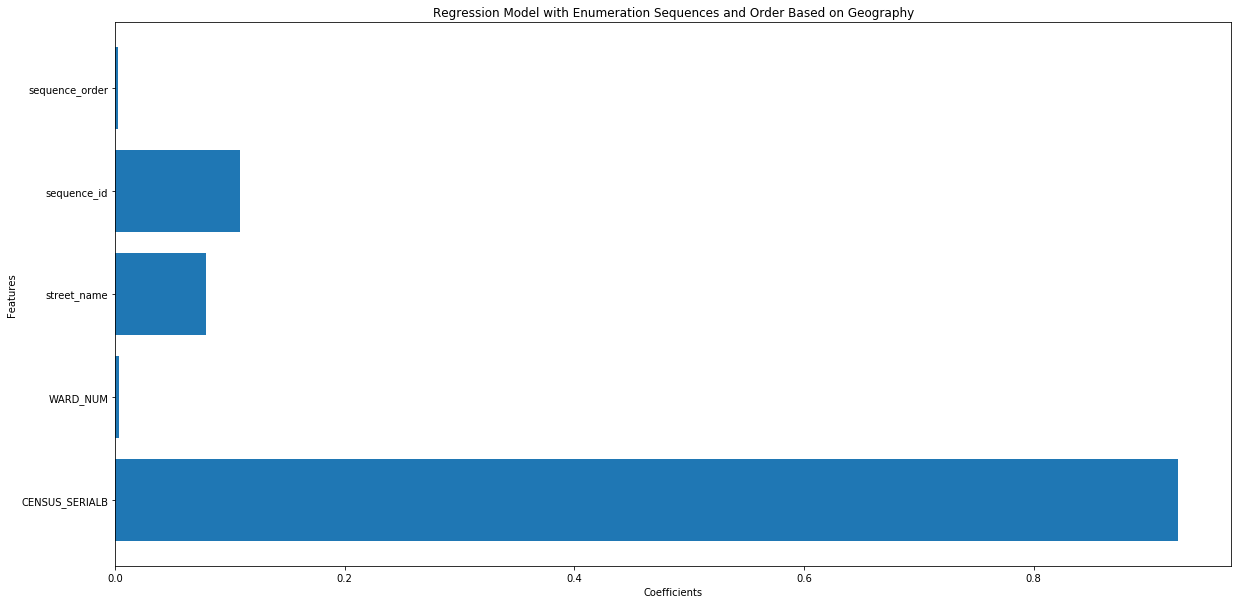

In [83]:
fig, ax = plt.subplots(1, figsize=(20,10))
ax.barh(model_lin_order.named_steps['preprocess'].get_feature_names(), model_lin_order.named_steps["regressor"].coef_[0])
ax.set_title("Regression Model with Enumeration Sequences and Order Based on Geography")
ax.set_xlabel("Coefficients")
ax.set_ylabel("Features")
plt.show()

In [84]:
#This is clearly not helping
model_lasso = Pipeline([('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB","WARD_NUM","street_name", "sequence_id", "sequence_order"])),
                            ('regressor', Lasso(alpha = 50))])
model_lasso.fit(train_X, train_y)
print("Training score:", model_lasso.score(train_X, train_y))
print("Test 1850 score:", model_lasso.score(test_1850_X, test_1850_y))
print("Test 1880 score:", model_lasso.score(test_1880_X, test_1880_y))

Training score: 0.9690120224067706
Test 1850 score: 0.8311204001349691
Test 1880 score: 0.8901369161238315
